In [4]:
using PyPlot
using DataFrames
using PyCall
@pyimport matplotlib.animation as anim  

In [5]:
function anima(x,edos, nombre::ASCIIString)
    fig = figure(figsize=(5,5))
    cuadros = [[plot(x,edos[:,i], "k")] for i in 1:length(edos[1,:])]
    
    animacion = anim.ArtistAnimation(fig, cuadros, interval=200, blit=true) 
    animacion[:save](nombre*".mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
end

function muestra_animacion(nombre::ASCIIString)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",base64(open(readbytes,nombre*".mp4")),"""" type="video/mp4"></video>"""))
end

muestra_animacion (generic function with 1 method)

In [6]:
G = readdlm("Greenland_input.txt", '\t')
Greenland_input = DataFrame()
Greenland_input[:x_scale] = G[:,1]
Greenland_input[:Bedrock] = G[:,2]
Greenland_input[:Surface] = G[:,3]
Greenland_input[:Longitude] = G[:,4]
Greenland_input;

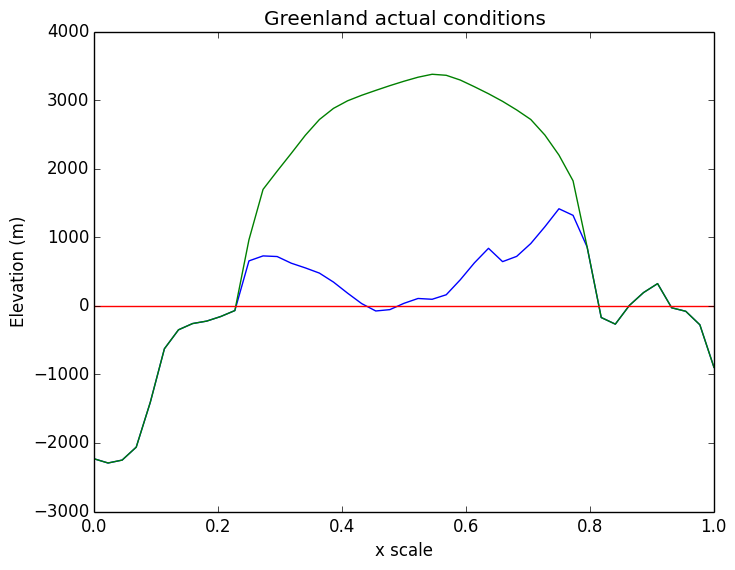

PyObject <matplotlib.text.Text object at 0x30b1d00d0>

In [7]:
plot(Greenland_input[:,1],Greenland_input[:,2])
plot(Greenland_input[:,1],Greenland_input[:,3])
plot(Greenland_input[:,1],zeros(length(Greenland_input[:,1])))
xlabel("x scale")
ylabel("Elevation (m)")
title("Greenland actual conditions")

In [8]:
ρ = 917
ρ_w = 1028
ρ_m =  3300
θ = 3000
B_0 = 1.928
C = 0.16612
K = 1.17
n = 3
p = 3
Q = 78800
R =  8.31
Tr = 280
g = 9.81

9.81

In [10]:
dx = 36000
ρ = 910
dt = 40
dtdx2 = 0.25*dt/(dx^2)
acont = 2.43e-16

2.43e-16

### Thickness

The thickness is the surface minus the bedrock:

$$Thickness\ = \ surface - bedrock. $$

### Slope

$$Slope = \frac{H_{i+1} + Bedrock_{i+1} - H_{i-1} - Bedrock_{i-1}}{2\ dx}$$

In [34]:
x_scale = G[:,1]
surface_0 = G[:,3]
bedrock = G[:,2]
h_old = surface_0 .- bedrock;

In [35]:
slope = zeros(45)
diffusion = zeros(45)
α_prim = zeros(43)
β_prim = zeros(43)
γ_prim = zeros(43)
δ = zeros(43)
α = zeros(43)
β = zeros(43)
γ = zeros(43)
ω = zeros(43)
♊ = zeros(43)
h_new = zeros(45)
h_temporal = zeros(45)
implicit = 1

for i in 1:43
    
    slope[i+1] = (h_old[i+2] + bedrock[i+2]- h_old[i] - bedrock[i])/(2*dx)
    diffusion[i+1] = -2 * acont * h_old[i+1]^3 * ρ^3 * g^3 * slope[i+1]^2 /5
    
    α_prim[i] = -dtdx2*(diffusion[i] + diffusion[i+1])
    β_prim[i] = -dtdx2*(diffusion[i+2] + 2*diffusion[i+1] + diffusion[i])
    γ_prim[i] = -dtdx2*(diffusion[i+1] + diffusion[i+2])
    
    α[i] = implicit * α_prim[i]
    β[i] = (β_prim[i] + 1)*implicit
    γ_prim[i] = implicit * γ_prim[i]
    ω[i] = γ[i] / β[i]
    
    δ[i] = h_old[i+1] + dt * mass_b[i+1] + α_prim[i] * bedrock[i] - ω[i] *bedrock[i+1] + γ_prim[i] * bedrock[i+2] +
    (1-implicit)*(γ_prim[i] * h_old[i+2] - (β[i] + 1)*h_old[i+1] + α_prim[i] * h_old[i])
    
    ♊[i] = (δ[i] + α[i] * h_old[i]) / β[i]
    
    h_temporal[i+1] = ω[i] * h_temporal[i + 2] + ♊[i]
    
    if h_temporal[i+1] < 0
        
        h_new[i+1] = 0
        
    else
        h_new[i+1] = h_temporal[i+1]
        
    end
    
end

In [12]:
h_new

45-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## Mass balance

La variable $T_f$ es el forzamiento de temperatura.

**Acumulación superficie**

$$a_{acc}=(-2.46257 + 0.1367 \lambda - 0.0016\lambda^2) \times 1.0533^{T_{fprim}},$$

donde $\lambda$ es la longitud oeste ($º W$).

**Ablación en superficie**

$$a_{abl} = min(1.4T_{ms};10),\ \text{Si}\ (T_{ms}\ge 0)$$

$$a_{abl} = 0,\ \text{Si}\ (T_{ms}< 0)$$

**Temperatura media anual**

$$T_{ma} = -5.31 -0.007992h + T_f$$

**Temperatura media verano**

$$T_{ms} = 7.29 - 0.006277h + T_f$$

**Balance de masa**

$$Mass_b = a_{acc} - a_{abl}$$

In [13]:
T_ma = zeros(45)
T_ms = zeros(45)
a_abl = zeros(45)
a_acc = zeros(45)
mass_b = zeros(45)
T_f = 0
longitud = G[:,4]

if T_f <= 0 
    T_fprim = T_f
else
    T_fprim = 0
end

for i in 1:45
    
    T_ma[i] = -5.31 - 0.007992*surface[i] + T_f
    T_ms[i] = 7.29 - 0.006277*surface[i] + T_f
    a_acc[i] = (-2.46257 + 0.1367*longitud[i] - 0.0016*longitud[i]^2)*1.0533^(T_fprim)
    
    if T_ms[i] >= 0
        
        a_abl[i] = min(1.4*T_ms[i], 10)
    else
        a_abl[i] = 0
        
    end
    mass_b[i] = a_acc[i] - a_abl[i]
    
end    

LoadError: LoadError: UndefVarError: surface not defined
while loading In[13], in expression starting on line 15

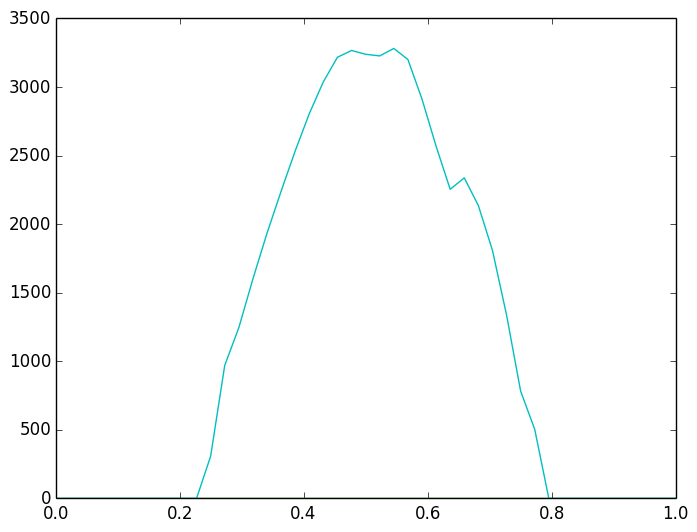

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31a9c5150>

In [10]:
plot(x_scale, h_new, "g")
plot(x_scale, h_old, "c")

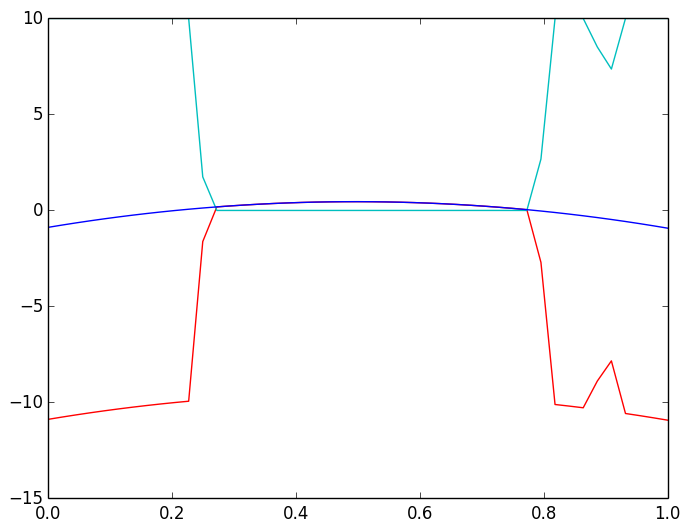

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31abe0c90>

In [11]:
plot(x_scale, mass_b, "r")
plot(x_scale, a_abl, "c")
plot(x_scale, a_acc, "b")

# Función 

In [36]:
x_scale = G[:,1]
surface_0 = G[:,3]
bedrock = G[:,2]
h_old = surface_0 .- bedrock;

In [37]:
longitud = G[:,4]

dx = 36000
dt = 40
dtdx2 = 0.25*dt/(dx^2)
acont = 2.43e-16
T_f = -10
implicit = 1

T_ma = zeros(45)
T_ms = zeros(45)
a_abl = zeros(45)
a_acc = zeros(45)
mass_b = zeros(45)
slope = zeros(45)
diffusion = zeros(45)
α_prim = zeros(43)
β_prim = zeros(43)
γ_prim = zeros(43)
δ = zeros(43)
α = zeros(43)
β = zeros(43)
γ = zeros(43)
ω = zeros(43)
♊ = zeros(43)
h_new = zeros(45)
h_temporal = zeros(45)
surface = zeros(45, 100)
surface[:,1] = surface_0

for t in 1:99
    
    if T_f <= 0 
        T_fprim = T_f
    else
        T_fprim = 0
    end

    for i in 1:45

        T_ma[i] = -5.31 - 0.007992*surface[i,t] + T_f
        T_ms[i] = 7.29 - 0.006277*surface[i,t] + T_f
        a_acc[i] = (-2.46257 + 0.1367*longitud[i] - 0.0016*longitud[i]^2)*1.0533^(T_fprim)

        if T_ms[i] >= 0

            a_abl[i] = max(-1.4*T_ms[i], -10)
        else
            a_abl[i] = 0

        end
        mass_b[i] = a_acc[i] + a_abl[i]

    end  

    for i in 1:43

        slope[i+1] = (h_old[i+2] + bedrock[i+2]- h_old[i] - bedrock[i])/(2*dx)
        diffusion[i+1] = -2 * acont * h_old[i+1]^3 * ρ^3 * g^3 * slope[i+1]^2 /5

        α_prim[i] = -dtdx2*(diffusion[i] + diffusion[i+1])
        β_prim[i] = -dtdx2*(diffusion[i+2] + 2*diffusion[i+1] + diffusion[i])
        γ_prim[i] = -dtdx2*(diffusion[i+1] + diffusion[i+2])

        α[i] = implicit * α_prim[i]
        β[i] = (β_prim[i] + 1)*implicit
        γ_prim[i] = implicit * γ_prim[i]
        ω[i] = γ[i] / β[i]

        δ[i] = h_old[i+1] + dt * mass_b[i+1] + α_prim[i] * bedrock[i] - ω[i] *bedrock[i+1] + γ_prim[i] * bedrock[i+2] +
        (1-implicit)*(γ_prim[i] * h_old[i+2] - (β[i] + 1)*h_old[i+1] + α_prim[i] * h_old[i])

        ♊[i] = (δ[i] + α[i] * h_old[i]) / β[i]

        h_temporal[i+1] = ω[i] * h_temporal[i + 2] + ♊[i]

        if h_temporal[i+1] < 0

            h_new[i+1] = 0

        else
            h_new[i+1] = h_temporal[i+1]

        end

    end


    surface[:,t+1] = h_new .+ bedrock
    
    h_old = h_new;
    
end

In [31]:
surface

45x100 Array{Float64,2}:
 -2230.77     -2230.77     -2230.77     …  -2230.77     -2230.77   
 -2292.63     -2292.63     -2292.63        -2292.63     -2292.63   
 -2250.39     -2250.39     -2250.39        -2250.39     -2250.39   
 -2061.61     -2061.61     -2061.61        -2061.61     -2061.61   
 -1406.43     -1406.43     -1406.43        -1406.43     -1406.43   
  -626.842     -626.842     -626.842    …   -626.842     -626.842  
  -350.303     -350.303     -350.303        -350.303     -350.303  
  -259.054     -259.054     -259.054        -259.054     -259.054  
  -223.468     -223.468     -223.468        -223.468     -223.468  
  -156.348     -156.348     -156.348        -156.348     -156.348  
   -69.5695     -68.0617     -66.5539   …     78.1953      79.7031 
   962.503      965.528      968.553        1258.95      1261.98   
  1697.24      1701.65      1706.06         2129.23      2133.64   
     ⋮                                  ⋱                          
  2197.69      2200.23 

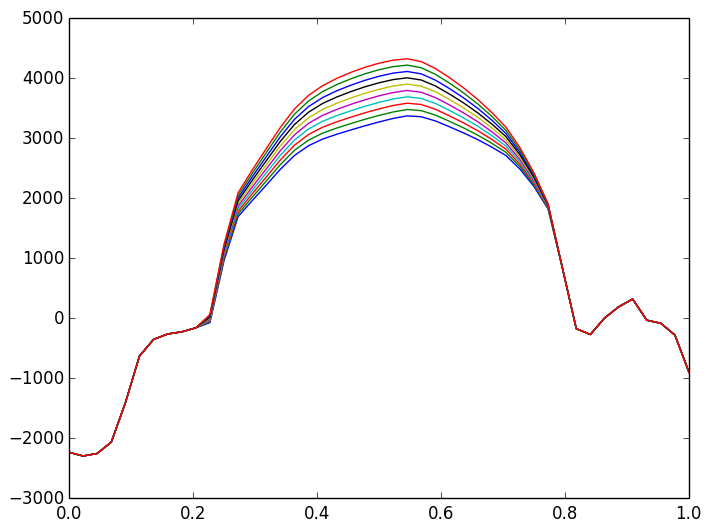

In [32]:
for i in 1:10:100
    plot(x_scale, surface[:,i])
    
end

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.3.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:32
 in anima at In[5]:3
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/claudiopierard/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /Users/claudiopierard/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading In[19], in expression starting on line 1
 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.3.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:32
 in anima at In[5]:3
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/claudiopierard/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /Users/claudiopierard/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading In[19], in expression starting on line 1


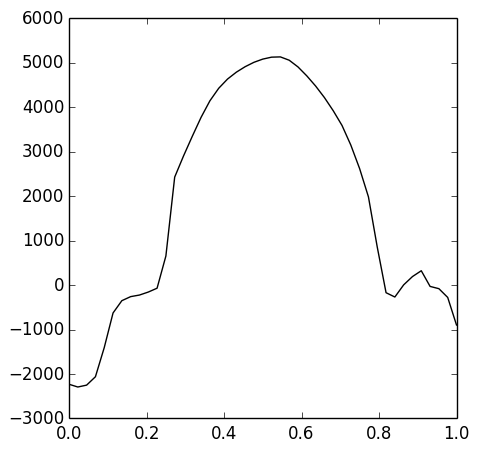

In [19]:
anima(x_scale, surface, "Greenland_8K")

In [20]:
muestra_animacion("Greenland_8K")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAgbZtZGF0AAACrQYF//+p3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0NiByMjU1NSAwYzIxNDgwIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTYgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAACbIZYiEABT//vfHT8Cm6Plmy51FPSEwitj6SCi9WOzQMnUAAAMAAAMADGj5q+cbg4CsoYAABLeL/Q1V3Zj+AAy7qY6CCCmvqkHEHtIAQ5hpYSazK7kt4GpUt7JoG7DHPBr1Us515nA163HkFwXxEyPS5dSvls1it8RwagkPwS+2Cc+v4JTlHoVvuN1DI01yjPiJuJoU+bcV1gFl/XkFL65L7hqGFNtZb4ORuE3uw9j9lHsXgWBUad8MG7xUhagDRSrqMitrX1DGQcaWrP8c0vTkDDYH5Gl+KMBKdKSb3csjNawMVTTdF2A4zyntmO/3p9DxJ7NxeVFUDG58KT41/3M2RfjGBXWOFHk0W0vBCBH2ltxcvbNHAqd4kx2A+wuKm/pQpLFtZbRBoHuK1oKJEoTeIe4Ro/fOBPaFARD3qQUAAj2tr+6JodvwdhF4uEEMdve1nvDrif72UhTyjBQEjxAls+tZQhs2TW114Rdl7WxbYOygn1heV6gALRezgNTj9V6GPRIgAJs5XVbLGVs8yvIQzIJ9UxIqNr0IPXJxp+7iIHQynhFZqowCTK0WA1mqMgOofF7mdFAgjQiDNQSRM79+jRs7bq9E5ASAuZyNqR8+GhNhSVYfkRdgcP+Ge3wvRDDNKvF8gOMX/BcNJJC4mjXHO2qWe9sX2l1HuxvAKBPFO7zcGwmSt1Uq0G+2ythRutKQoVOLYuC/NojBaMYUP45YUlLd+Pj0/TfN04vwxa8PSJCWnokzTw3If7kNIIVs2bx1NHclXrQRdVP4+6sbKjFiHhOQuqFUidenq778DwjcX52fP+P2AV/8/T820qPP/xAA1BGEuzWcuKn7MEzIDgQjPawJq7bYZt4F9Eq4iFXQEZ8u49JlzQcuxbupi2a/q1RW8PRkdkPg133v//rBrd58olJ4u+59P387R8j9wszKYv8N/3rAChTtRij88OfR+g1/+u6jHZYwqvEHz0DGUUVnuL0tZLp7zulb5MOgaq/a2d5tT2sTZSiyyoACTlL8it++stLyGO+mMuXoaU7xlMX4puva1gE/+rtmkP4tDuYONVyz/qtLmfdZFiJMcYWTuhT76CIMJ1evu4DiC2tCWhmyiP3l0affmr90vjq7iPLu7PtrD9H11dQiSv9U3Q6ncFgX/c4pQRy5nJZRikx+jZbKQ69dV74f3dQAZIkW4nQrH38KGUXAWvZCh4tC4whvq2y3eg1AeYeioZGlxk1Y3eJmJ9Lixkp9cW25UIu7VVtIsxupyiopCE5RJ2ICl7P/VqOKXWyq5Y5snAIQb4ajxZzCkQPzflk35c0oBWCaQ9rlDNnKnLegJf26sFRLWvuSMN9MN3dUHibX7zDDTsRqXR+7luMO5uC0u9IJnnc0AM2yFerkyJdoYaEwgA2b5Vj/NMKVCfFI3P50At5LulPRgB7IIFyaBtYPkIjHzYwI3s0oVKZlEqGl//cqQxoBv7LyiwOF4DLxMuj+8rYA/0l4CtjcosoyVqZvukziSWHbH7Da2vS7jDe7tJE74hBQk7H3rkLLvY0vhziubJjE6GNWATxJeC2h1yCPYhg2lLj97sSW/2tG+0w+9pngbIuh54OKOIgphDxNrk23BI0md0V6OgcNkop5uwHwKOzzhpnwCqSVB8UoLmOdWtz6sPUf5xM5zyqTkbizbLS2/XhN1H6aNIOyeePz2ZShhtp2jqF40GzzB9WFsdUhd2HGGIGYYwyI3gt77VaNQCEJwOfKK9X8FEXfwvLD8dr+8/IA59g5JamLDmjNlBFxnPe7GIXspZ5K4h5z1od7mpWbjhsVwQ0U4CCm2V3lGdpm6tAR+EDqBwLamBFZOMIrDhJhmy8zTb52B08KBNOn5YvC8N9w6IqRkarmFZZieCuzpz3aYwwqUZ6O5LKm5dyRI0jMTKXJ+v2TBadM125FFbe0qKZYuO5cQH8TBOELYXYY/uuZH2P0K4eELUUWQP0OvIdEuuLdiGMDehhLYIEaOIxzxkCuPwvUxlIowNem0/hR5o5s9lS+Ln/aHHRhNGdWO4PaXF4Lob8E+Z7O+kaq/E3B2AxySc14jaOJkuSywSolYWXvnovJYRN/n6t0Z7s/9mh/Zwgs9X5YGFR18j7ZmuRdxItWu4k3fDO2aoyraPRf7xfxgdhN61umYJzqsc8Own8dgd2RIxeslRGWZMhH6jsVu6CX+QVev3SvL53EFLplT4bwx/nkWXb53F4SeBZb3mOvuIuiDa6o+J41a0iP+jl4v1T85OVc9wzDYaP/zeKirpHfppBigz/se+M65Pu8GyKMAxOOGYurLeqlJgmErBA6xtnQ94ys0BErEiSrpMgjgR6AtFZd3fyjC6KBxPp11928RW2dMugiM/4XZfMHDgprxp7PaN56Pjz7saa6fpSqsuyaBrZYApWpNNyo8hp8wUSB1IP6BjzXMhIjmuTWsijJZOOzsZHo89cDsLPZx70dikI8I1uG0vmq55duNtEa3DtN6PThqEI6/PVMXLsUNVrZ5/1M61N3LfmjRpS3absNPfbjh9nR2KBlADurpnHOJlr5GexF/MJpRH5zD8fTIysz82IEeYHdz7afLrYa7rIqF+GIVG5YKwFmsjUhIg2rLIWHJhskrhX1VB8Cqoa91Zf5GeVEf0gQt1g+5j0qJnRSidekaYK9V4MeEzFY3pRcZksUK2eZorVSy3A0M9MPwuu4kDLZjzBNP3zMi2Blj/1H3MjTfgW7rM5EtiF2jgYbXzuGgSwe+cUa3sq52D6Ch4KQep667MaIM2ctknDF/xHhWhgN5f/+g5uwY87BH5KDKUuruoi6O6q27klCWlTDNigrYyh0dmtNAwIRwI8tI5UaXk8oIC4KINUmAK35oooNUllFGKGt7vbCd8v4tyujz4zqy5kZsfJW3i4p+WFGuQMJmfFDg+AztVvMsCImfZS4/zRfqC954isCvMr47c2vPlX+aWWpZx/xHneKgqIT1gYjg1e